In [1]:
!pip install fastai --upgrade
!pip install timm wwf

     |████████████████████████████████| 194kB 19.5MB/s 
     |████████████████████████████████| 61kB 10.1MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 245kB 17.4MB/s 
  Created wheel for wwf: filename=wwf-0.0.10-cp36-none-any.whl size=23155 sha256=641330fffeddad7821af2df6b5ddcefc5855d8ce1236309cc682aa7395736cd0
  Stored in directory: /root/.cache/pip/wheels/c7/22/a7/30cb5077503f2c5d1c0af9187090604237d9e075154d833eb5
Successfully built wwf


In [2]:
!wget https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1 -O erm.zip

--2021-02-08 17:26:53--  https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/cb3g53z4pbtaqvl/erm.zip [following]
--2021-02-08 17:26:53--  https://www.dropbox.com/s/dl/cb3g53z4pbtaqvl/erm.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucde4c813e408116d3564c49950f.dl.dropboxusercontent.com/cd/0/get/BIhKhIO6gTrQ-21JXFgdSn_dT5HOVAIR9c7UqGYz0u2SKb4O-Aeszdf8mkgBOCJRVqU1KZaT0kE3H450zHNEfbbR6fPrpLbOICKbnbYvw5GOnt2BxJVkh1vRWNHJvgX7YsU/file?dl=1# [following]
--2021-02-08 17:26:54--  https://ucde4c813e408116d3564c49950f.dl.dropboxusercontent.com/cd/0/get/BIhKhIO6gTrQ-21JXFgdSn_dT5HOVAIR9c7UqGYz0u2SKb4O-Aeszdf8mkgBOCJRVqU1KZaT0kE3H450zHNEfbbR6fPrpLbOICKbnbYvw5GOnt2BxJVkh1vRWNHJ

In [3]:
!unzip erm.zip

Archive:  erm.zip
   creating: dataset/
   creating: dataset/test/
   creating: dataset/test/no/
  inflating: dataset/test/no/anonymized_1421704.jpg  
  inflating: dataset/test/no/anonymized_336537.jpg  
  inflating: dataset/test/no/anonymized_569526.jpg  
  inflating: dataset/test/no/anonymized_196860.jpg  
  inflating: dataset/test/no/anonymized_920184.jpg  
  inflating: dataset/test/no/anonymized_1348815.jpg  
  inflating: dataset/test/no/anonymized_225304.jpg  
  inflating: dataset/test/no/anonymized_816099.jpg  
  inflating: dataset/test/no/anonymized_260226.jpg  
  inflating: dataset/test/no/anonymized_1619231.jpg  
  inflating: dataset/test/no/anonymized_1314755.jpg  
  inflating: dataset/test/no/anonymized_1182585.jpg  
  inflating: dataset/test/no/anonymized_656024.jpg  
  inflating: dataset/test/no/anonymized_198917.jpg  
  inflating: dataset/test/no/anonymized_246204.jpg  
  inflating: dataset/test/no/anonymized_324557.jpg  
  inflating: dataset/test/no/anonymized_492637.jpg

In [4]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *

In [5]:
path = Path('dataset/')
trainPath = path/'train'
testPath = path/'test'

In [6]:
def getDataBlock(presize=512,size=256):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])

In [7]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=64)

In [8]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='efficientnet_b3')
]

In [9]:
import timm
timm.list_models('*efficientnet_b3*')

['efficientnet_b3',
 'efficientnet_b3_pruned',
 'efficientnet_b3a',
 'tf_efficientnet_b3',
 'tf_efficientnet_b3_ap',
 'tf_efficientnet_b3_ns']

In [10]:
learn = timm_learner(dls512, 'efficientnet_b3',cbs = callbacks,metrics=[accuracy,Precision(),Recall()]).to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra2-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_ra2-cf984f9c.pth


SuggestedLRs(lr_min=3.311311274956097e-07, lr_steep=2.75422871709452e-06)

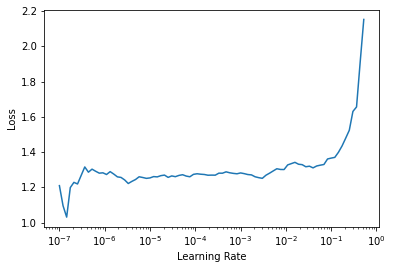

In [11]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.312074,0.882595,0.539755,0.574468,0.472303,00:29


Better model found at epoch 0 with valid_loss value: 0.882594883441925.


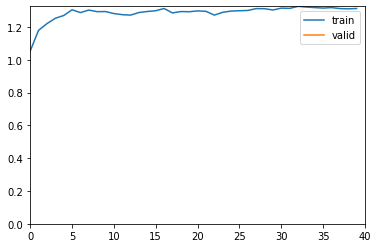

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.344688,0.880160,0.538226,0.565079,0.518950,00:36
1,1.310696,0.867247,0.542813,0.568323,0.533528,00:34
2,1.336510,0.869315,0.541284,0.567398,0.527697,00:34
3,1.291348,0.849710,0.550459,0.579288,0.521866,00:34
4,1.277957,0.843138,0.558104,0.585987,0.536443,00:35
5,1.306968,0.834015,0.562691,0.592233,0.533528,00:35
6,1.267261,0.842476,0.553517,0.583607,0.518950,00:35
7,1.233794,0.833938,0.558104,0.583333,0.551020,00:34
8,1.239464,0.829580,0.567278,0.587719,0.586006,00:35
9,1.247635,0.834248,0.558104,0.588235,0.524781,00:35


Better model found at epoch 0 with valid_loss value: 0.880160391330719.


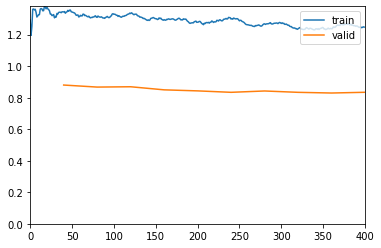

Better model found at epoch 1 with valid_loss value: 0.8672473430633545.
Better model found at epoch 3 with valid_loss value: 0.8497098088264465.
Better model found at epoch 4 with valid_loss value: 0.8431380391120911.
Better model found at epoch 5 with valid_loss value: 0.834014892578125.
Better model found at epoch 7 with valid_loss value: 0.833938479423523.
Better model found at epoch 8 with valid_loss value: 0.8295801281929016.


In [12]:
learn.fine_tune(10,base_lr=1e-5)

In [13]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

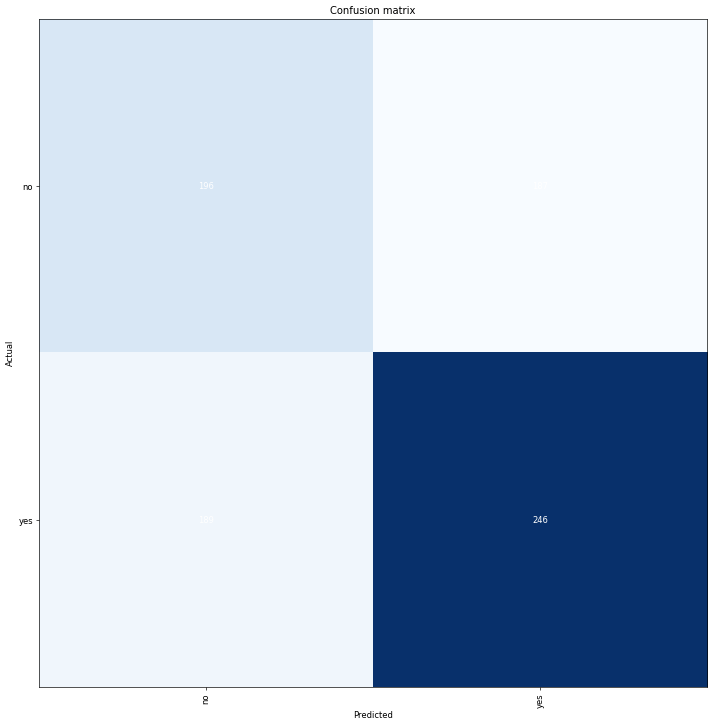

In [14]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [15]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5403422713279724.


(#4) [1.2061352729797363,0.5403422713279724,0.5681293302540416,0.5655172413793104]

In [16]:
learn.export(fname='resnet50.pkl')